In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
import random
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
#import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu

In [3]:
from trim_networks import *
from fit_sbm import *

In [4]:
def FilterByGraph(g, g_ref):
    genes = g.vp.genes

    keep = g.new_vertex_property("bool", True)
    for v in g.get_vertices():
        if genes[v] not in g_ref.vp.genes:
            keep[v] = False
    tv = GraphView(g, vfilt=keep)
    g = Graph(tv, prune = True)
    return g


def KeepRandomVertices(g, num_vertices_to_keep):
    keep = g.new_vertex_property("bool")
    vertices = list(g.get_vertices())
    
    # Select a random subset of vertices
    subset_vertices = np.random.choice(vertices, num_vertices_to_keep, replace=False) 
    
    # Mark the selected vertices to keep
    for v in subset_vertices:
        keep[v] = True
    
    # Create a new graph view with the filtered vertices
    tv = GraphView(g, vfilt=keep)
    
    # Create a new graph from the graph view and prune unused vertices
    g_subset = Graph(tv, prune=True)
    
    return g_subset


def KeepRandomSubset(g, subset_ratio):
    keep = g.new_vertex_property("bool")
    vertices = list(g.get_vertices())
    num_vertices = len(vertices)
    num_subset = int(num_vertices * subset_ratio)
    
    # Select a random subset of vertices
    subset_vertices = np.random.choice(vertices, num_subset, replace=False)
    
    # Mark the selected vertices to keep
    for v in subset_vertices:
        keep[v] = True
    
    # Create a new graph view with the filtered vertices
    tv = GraphView(g, vfilt=keep)
    
    # Create a new graph from the graph view and prune unused vertices
    g_subset = Graph(tv, prune=True)
    
    return g_subset

In [5]:
folder = "../data/output/SBM/graphs/"
#g_body = load_graph(folder + "VOOMCounts_CPM1_body_ctrl_249ind_counts3M_covfree_Aug3121.xml.gz")
g_head = load_graph(folder + "VOOMCounts_CPM1_head_ctrl_248ind_counts3M_covfree_Aug3121.xml.gz")

#g_dict = {"head": g_head, "body": g_body}

In [ ]:
g_total = KeepRandomVertices(g_head, 150)
g_total
corr = g_total.edge_properties["spearman"]
g_total.ep.weight = g_total.new_edge_property("double", (2*np.arctanh(corr.a)))
g_total

<Graph object, undirected, with 150 vertices and 11175 edges, 1 internal vertex property, 6 internal edge properties, at 0x7ff1a25fc810>

In [124]:
g_050 = filterByFDR(g_total, 0.5, True)
g_025 = filterByFDR(g_total, 0.25, True)
g_1e1 = filterByFDR(g_total, 1e-1, True)
g_5e2 = filterByFDR(g_total, 5e-2, True)
g_1e2 = filterByFDR(g_total, 1e-2, True)

In [125]:
g_050 = FilterByGraph(g_050, g_1e2)
g_025 = FilterByGraph(g_025, g_1e2)
g_1e1 = FilterByGraph(g_1e1, g_1e2)
g_5e2 = FilterByGraph(g_5e2, g_1e2)
g_1e2 = FilterByGraph(g_1e2, g_1e2)
len(g_050.get_vertices()) len(g_025.get_vertices()), len(g_1e1.get_vertices()), len(g_5e2.get_vertices()), len(g_1e2.get_vertices())

(47, 47, 47, 47)

In [126]:
state_tot = minimize_nested_blockmodel_dl(g_tot, 
                                          state_args=dict(recs=[g_tot.ep.weight],
                                          rec_types=["real-normal"]))

In [128]:
state_025 = minimize_nested_blockmodel_dl(g_025, 
                                          state_args=dict(recs=[g_025.ep.weight],
                                          rec_types=["real-normal"]))


In [129]:
mcmc_equilibrate(state_025, wait=100, nbreaks=2, mcmc_args=dict(niter=10))

(825.468268969897, 909141, 221691)

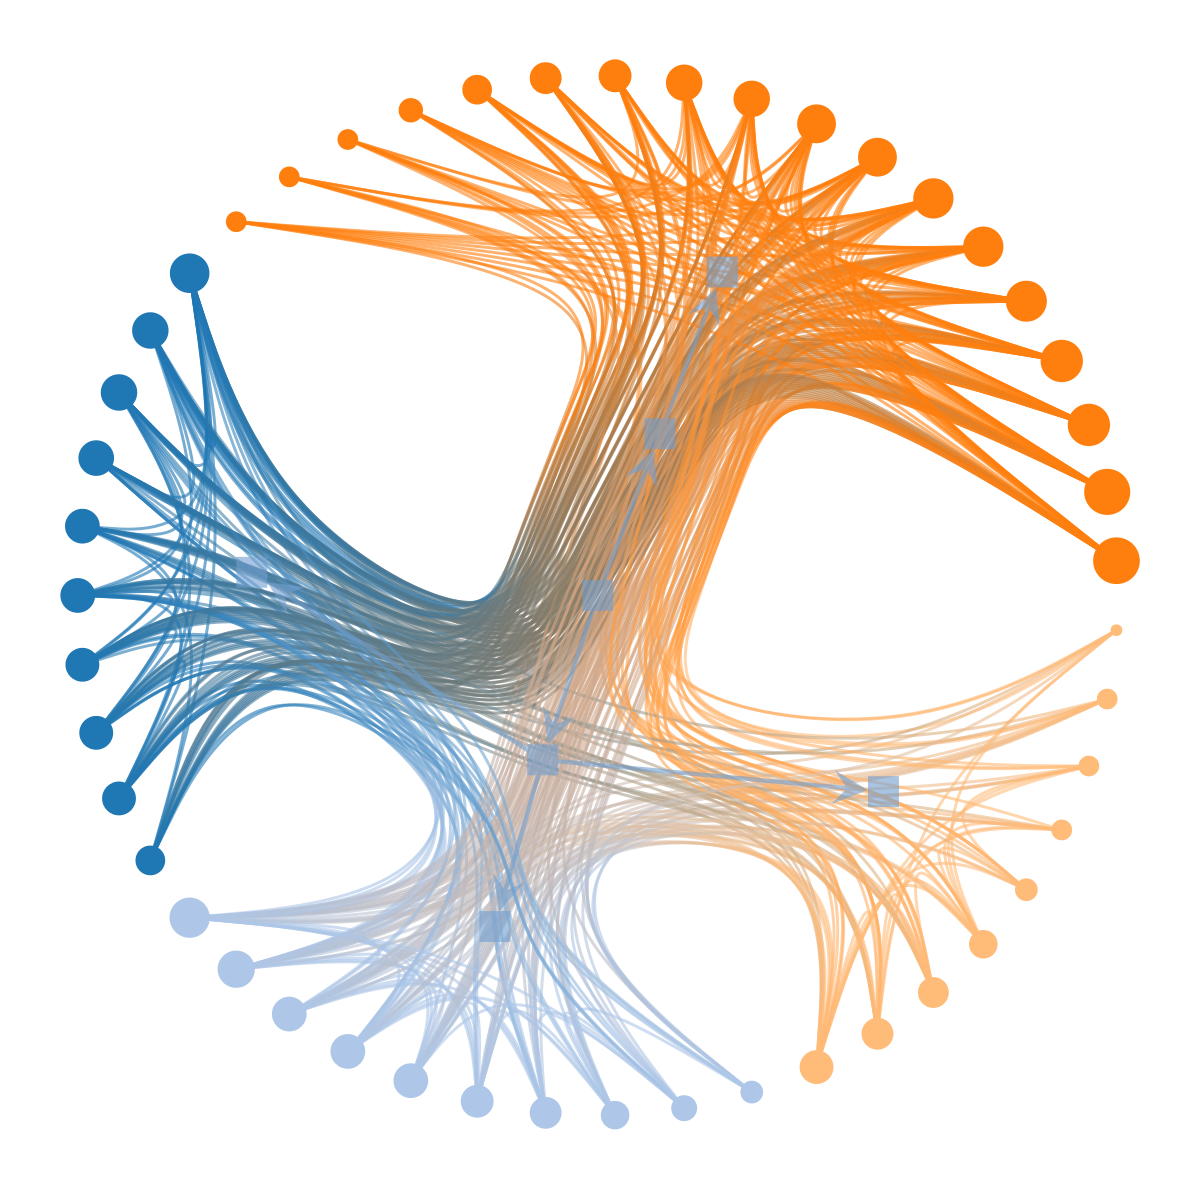

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff16e55a010, at 0x7ff1a265c6d0>,
 <GraphView object, directed, with 54 vertices and 53 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff16e43c490, at 0x7ff192405710>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff16e43c490, at 0x7ff16e50d150>, False), at 0x7ff16e43c490>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff16e43c490, at 0x7ff1922fe510>)

In [130]:
state_025.draw()

In [133]:
color = state_025.get_bs()[0]
color

PropertyArray([35, 30,  2, 30, 35, 19,  2, 35, 19, 30, 19,  2, 35, 19, 19,
                2, 19, 19, 30,  2, 35, 30,  2, 19, 35, 19,  2, 30, 30, 30,
                2, 30, 30, 35, 35, 30, 35,  2, 30, 30,  2, 30, 30, 30, 30,
               30, 19], dtype=int32)

In [131]:
state_1e1 = minimize_nested_blockmodel_dl(g_1e1, init_bs=state_025.get_bs(), 
                                          state_args=dict(recs=[g_1e1.ep.weight],
                                          rec_types=["real-normal"]))
mcmc_equilibrate(state_1e1, wait=100, nbreaks=2, mcmc_args=dict(niter=10))


(690.2936840846767, 1993535, 754934)

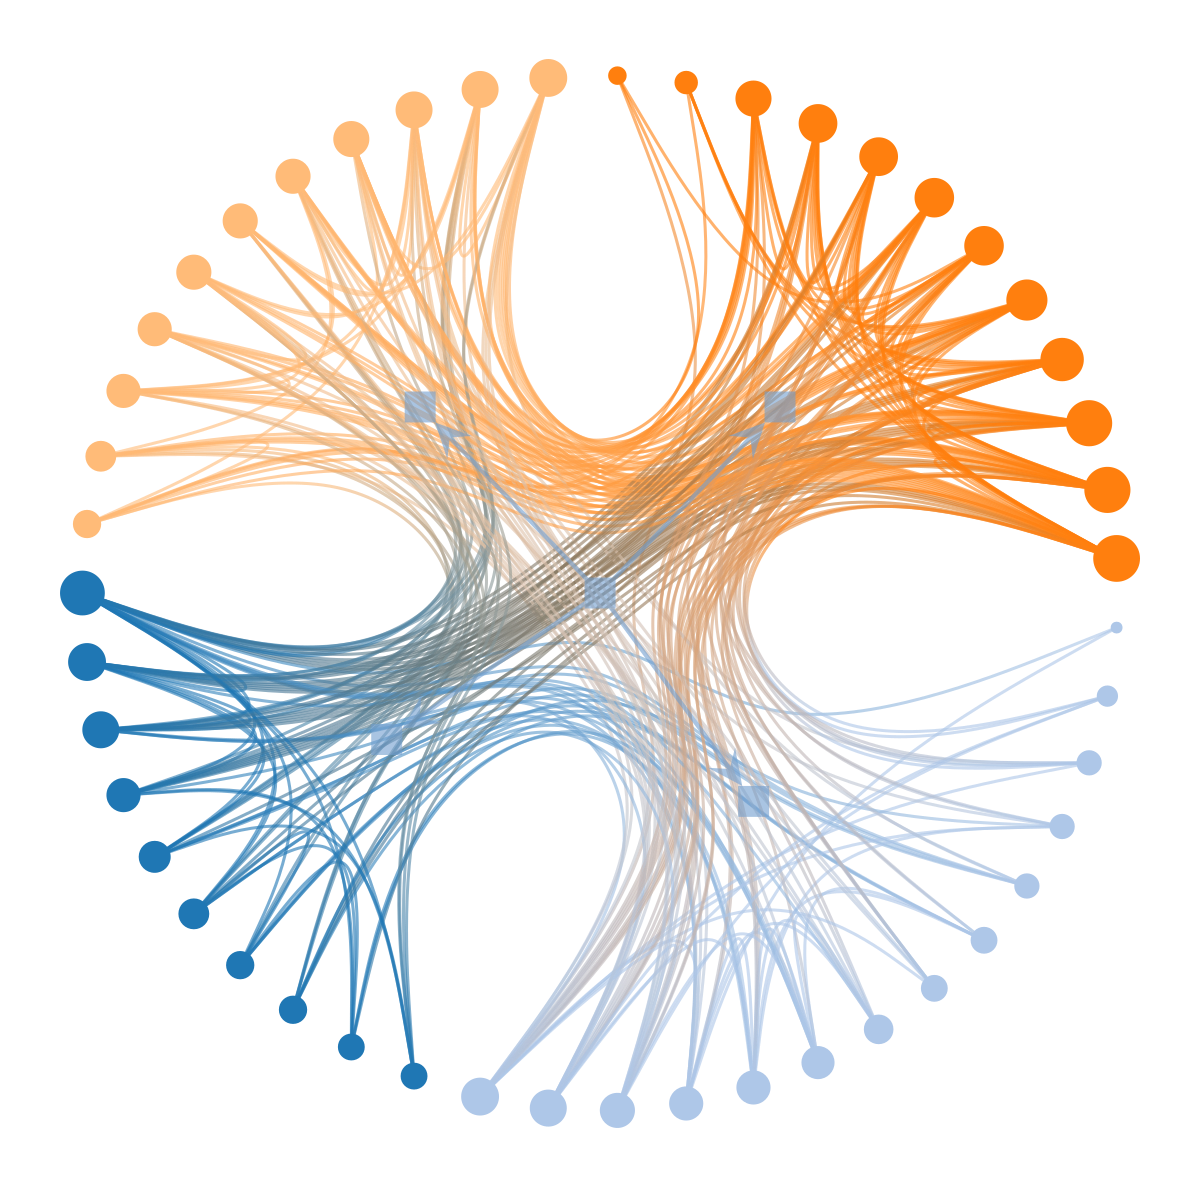

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff1922bf290, at 0x7ff16e41c2d0>,
 <GraphView object, directed, with 52 vertices and 51 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff16e5193d0, at 0x7ff16e53b150>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff16e5193d0, at 0x7ff16e50f050>, False), at 0x7ff16e5193d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff16e5193d0, at 0x7ff16e34dbd0>)

In [135]:
state_1e1.draw()

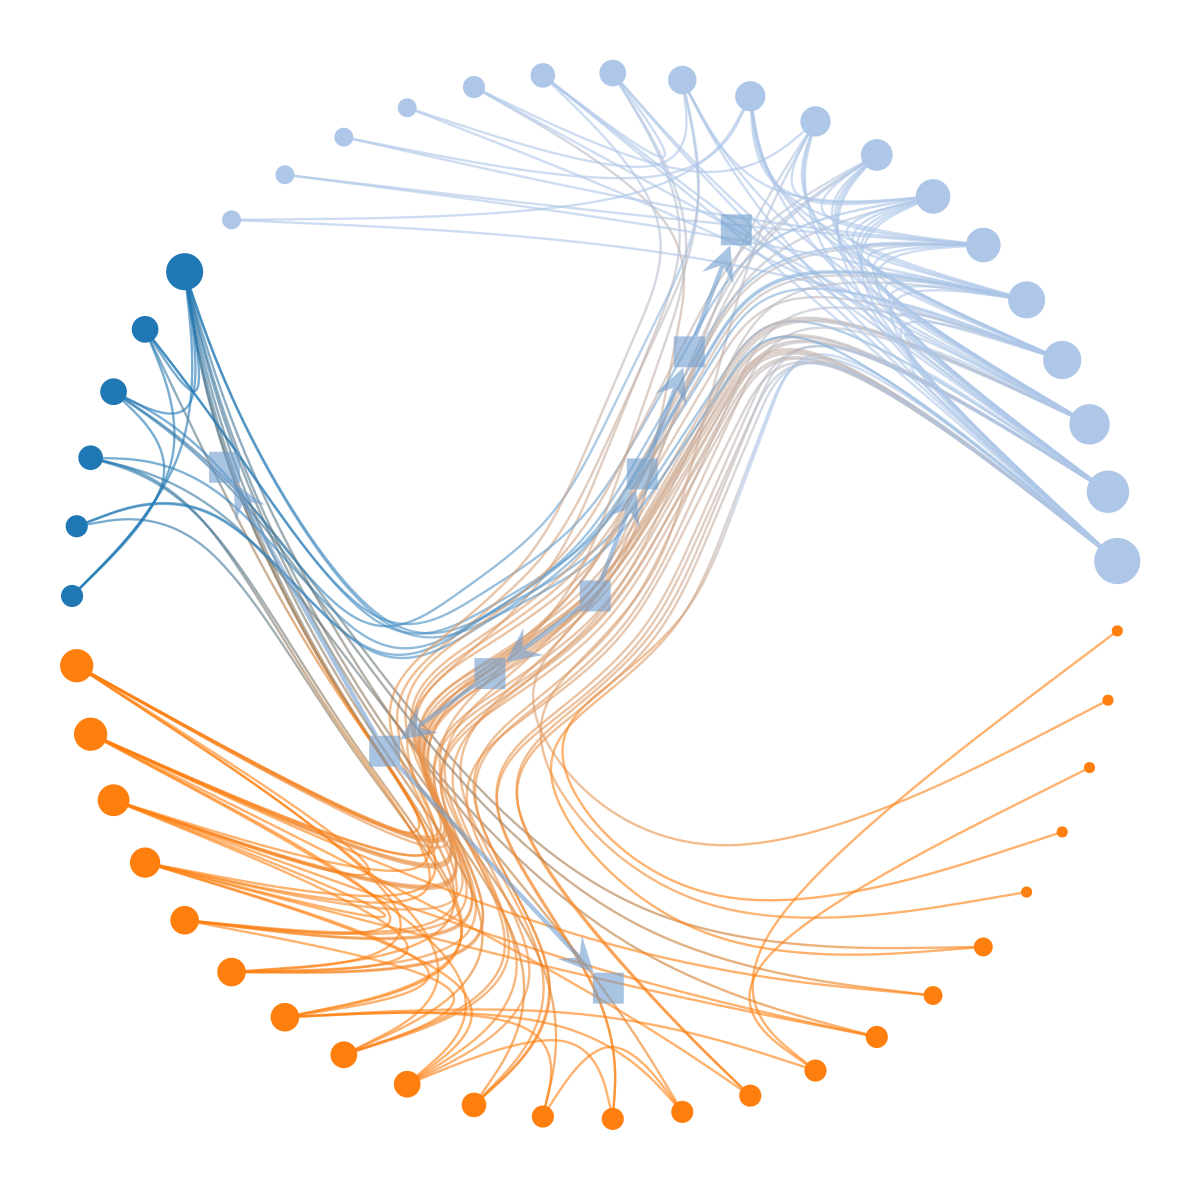

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff16e43dd10, at 0x7ff1a25a8cd0>,
 <GraphView object, directed, with 55 vertices and 54 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7ff619f6bc50, at 0x7ff192453a10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7ff619f6bc50, at 0x7ff192452490>, False), at 0x7ff619f6bc50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff619f6bc50, at 0x7ff1922df110>)

In [136]:
state_5e2 = minimize_nested_blockmodel_dl(g_5e2, init_bs=state_025.get_bs(), 
                                          state_args=dict(recs=[g_5e2.ep.weight],
                                          rec_types=["real-normal"]))
mcmc_equilibrate(state_5e2, wait=100, nbreaks=2, mcmc_args=dict(niter=10))
state_5e2.draw()

In [ ]:
state_1e2 = minimize_nested_blockmodel_dl(g_1e2, init_bs=state_025.get_bs(), 
                                          state_args=dict(recs=[g_1e2.ep.weight],
                                          rec_types=["real-normal"]))
mcmc_equilibrate(state_1e2, wait=100, nbreaks=2, mcmc_args=dict(niter=10))
state_1e2.draw()

In [137]:
state_1e3 = minimize_nested_blockmodel_dl(g_1e3, init_bs=state_025.get_bs(), 
                                          state_args=dict(recs=[g_1e3.ep.weight],
                                          rec_types=["real-normal"]))
mcmc_equilibrate(state_1e2, wait=100, nbreaks=2, mcmc_args=dict(niter=10))
state_1e3.draw()

In [ ]:
[partition_overlap(state_025.get_bs()[0], state_025.get_bs()[0], norm=True),
partition_overlap(state_025.get_bs()[0], state_1e1.get_bs()[0], norm=True),
partition_overlap(state_025.get_bs()[0], state_1e2.get_bs()[0], norm=True),
partition_overlap(state_025.get_bs()[0], state_1e3.get_bs()[0], norm=True)]

ValueError: Partitions need to have the same number of elements

In [105]:
g_1e2

<Graph object, undirected, with 112 vertices and 853 edges, 2 internal vertex properties, 6 internal edge properties, at 0x7ff1ab17e750>

In [ ]:
def density(g):
    N = len(g.get_vertices())
    Et = (N * N - N)/2
    E = len(g.get_edges())
    density = E/Et
    return density

In [87]:
[density(g_025), density(g_1e1), density(g_1e2), density(g_1e3)]

[0.4333976833976834,
 0.2111888111888112,
 0.13722651222651222,
 0.07850707850707851]

In [ ]:
g_ref = Graph(tv_head_1e2, prune = True)
g = Graph(tv_head_1e1, prune = True)



g_1e1 = FilterByGraph(g, g_ref)
g_1e1.ep.z_s = g_1e1.new_edge_property("double", (2*np.arctanh(g_1e1.ep["spearman"].a)))


In [ ]:
state_head_1e1 = minimize_nested_blockmodel_dl(g_1e1, init_bs=bs_head, 
                                               state_args=dict(recs=[g_1e1.ep.z_s],
                                               rec_types=["real-normal"]))

NameError: name 'bs_head' is not defined

In [ ]:
mcmc_equilibrate(state_head_1e1, wait=100, nbreaks=1, mcmc_args=dict(niter=10))

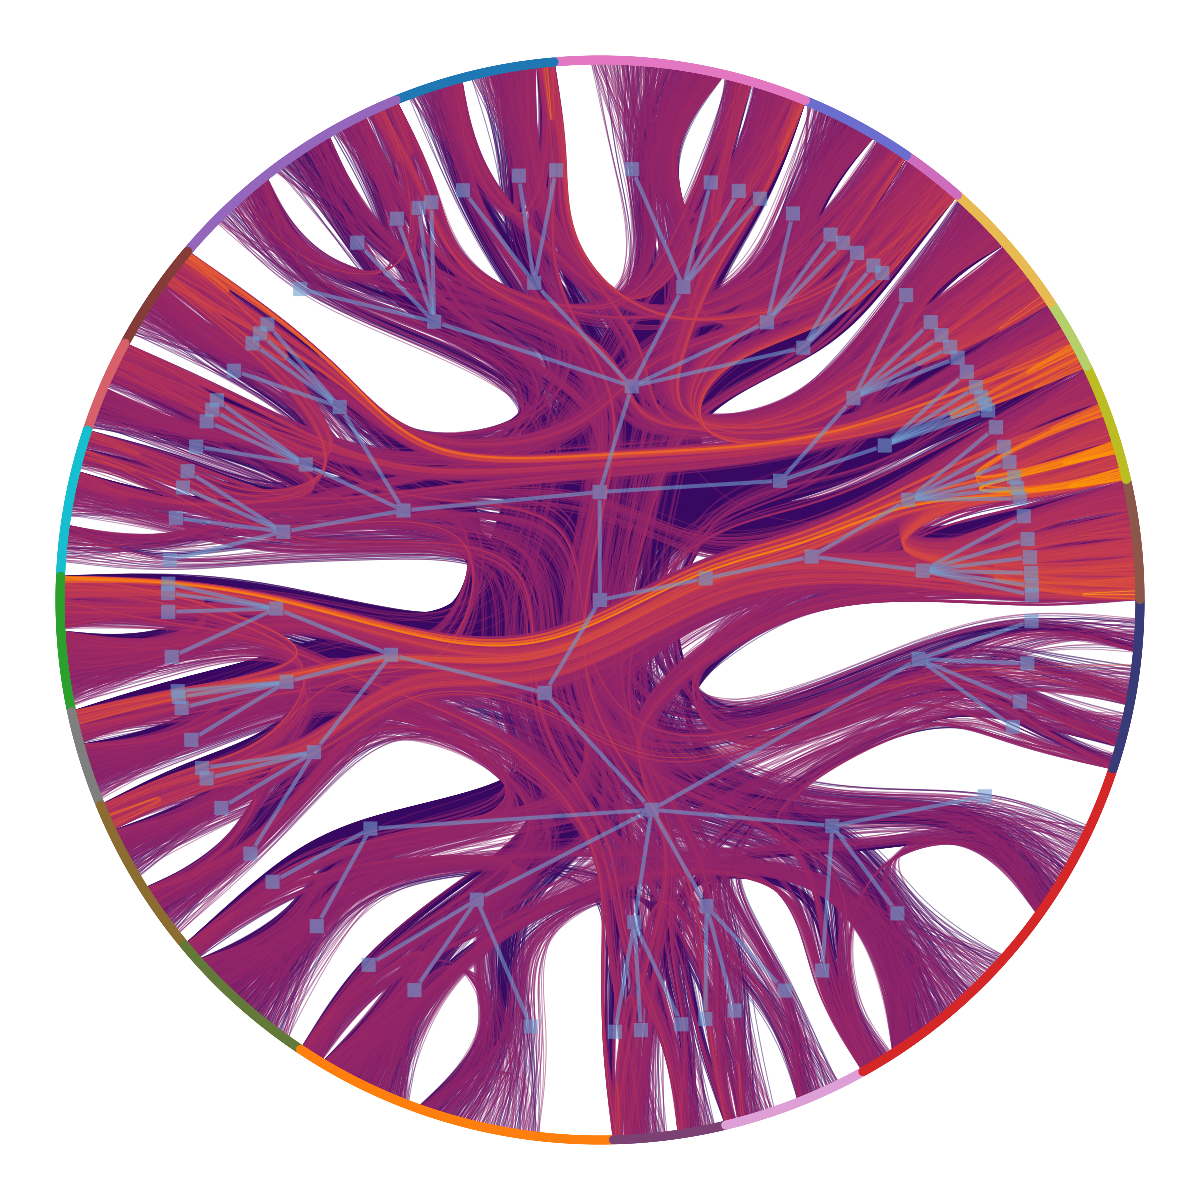

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad8f5d7ad0, at 0x7fad8e0f0590>,
 <GraphView object, directed, with 5374 vertices and 5373 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fad753b0050, at 0x7fad753b0e90>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fad753b0050, at 0x7fad753b0f10>, False), at 0x7fad753b0050>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad753b0050, at 0x7fad85ba9a10>)

In [ ]:
tv_head_1e2.vp.level_1 = tv_head_1e2.new_vertex_property("double", state_head_1e2.get_bs()[1][state_head_1e2.get_bs()[0]])

state_head_1e2.draw(
            eorder=tv_head_1e2.ep.z_s,
            #edge_pen_width = gf_head.ep.z_s,
            edge_color=prop_to_size(tv_head_1e2.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 15,
            hedge_pen_width = 3,
            vertex_color = tv_head_1e2.vp.level_1,
            vertex_fill_color = tv_head_1e2.vp.level_1,
            subsample_edges = 30000)

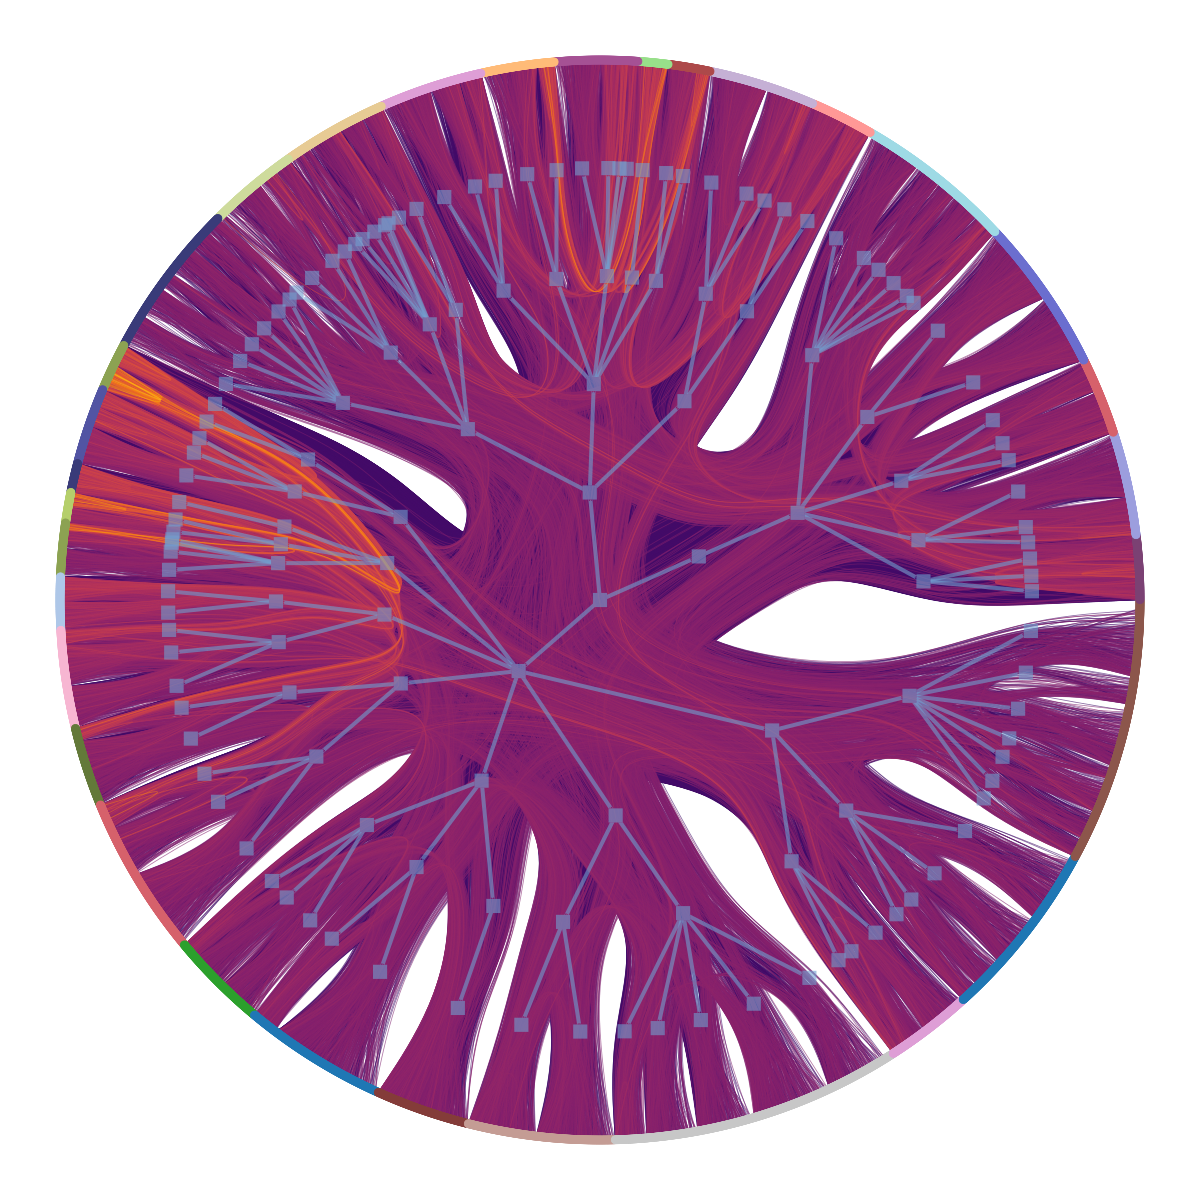

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad8e0f8350, at 0x7fad7527fc90>,
 <GraphView object, directed, with 5409 vertices and 5408 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fad753c1dd0, at 0x7fad753bda50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fad753c1dd0, at 0x7fad753c0b50>, False), at 0x7fad753c1dd0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad753c1dd0, at 0x7fad753c01d0>)

In [ ]:
g_1e1.vp.level_1 = g_1e1.new_vertex_property("double", state_head_1e1.get_bs()[1][state_head_1e1.get_bs()[0]])

state_head_1e1.draw(
            eorder=g_1e1.ep.z_s,
            #edge_pen_width = gf_head.ep.z_s,
            edge_color=prop_to_size(g_1e1.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 10,
            hedge_pen_width = 2,
            vertex_color = g_1e1.vp.level_1,
            vertex_fill_color = g_1e1.vp.level_1,
            subsample_edges = 30000)

In [ ]:
partition_overlap(state_head_1e1.get_bs()[0], state_head_1e2.get_bs()[0], norm=True)

0.59456377114617

In [ ]:
B = len(state_head_1e1.get_bs()[0])
N = len(g_1e1.get_vertices())
x = np.random.randint(0, 10, N)
y = np.random.randint(0, 10, N)
partition_overlap(x, y)

0.11955901919787112

In [ ]:
def filterByCorr(g, cutOff):
    # Filtering edges
    corr = g.edge_properties["spearman"]
    sign = g.new_ep("bool", True)
    sign.a = np.array(corr.a > cutOff)

    tv = GraphView(g, efilt=sign)
    return tv


In [ ]:

g_ref_trim_1e2 = filterByCorr(g_ref, 0.3)
pos = arf_layout(g_ref_trim_1e2)
graph_draw(g_ref_trim_1e2, pos = pos, edge_pen_width = g_ref_trim_1e2.ep.weight ,             vertex_fill_color=g_1e1.vp.level_1)

In [ ]:

g_ref_trim_1e1 = filterByCorr(g_1e1, 0.3)
graph_draw(g_ref_trim_1e1, pos = pos, edge_pen_width = g_ref_trim_1e1.ep.weight , vertex_fill_color=g_1e1.vp.level_1)